In [31]:
#Implementation of a normal RNN with L1 regularization for comparision with the spatially embedded rnn.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import bct
import pandas as pd

In [32]:
class MazeDataSet(Dataset):
    def __init__(self,data,labels):
        if data.shape[0] != labels.shape[0]:
            raise Exception("Number of data examples doesn't match number of labels",data.shape[0],labels.shape[0])
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        data_point = self.data[idx]
        transform = transforms.ToTensor()
        data_point = torch.squeeze(transform(data_point))
        return data_point, self.labels[idx]

class mazeGeneratorI():
    '''
    Objects of the mazeGeneratorI class can create numpy and tf datasets of the first choice of the maze task.
    Task structure:
        Goal presentation, followed by delay period, followed by choice options.
    Response:
        One response required from agent at end of episode. Direction (Left, Up, Right, Down) of first step.
    Encoding:
        Both observations and labels are OneHot encoded.
    Usage:
        The two only function a user should need to access are "construct_numpy_data" and "construct_tf_data"
    Options:
        Both data construction methods have an option to shuffle the labels of data.
        The numpy data construction method allows to also return the maze identifiers.
    '''
    def __init__(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.version = 'v1.2.0'

        # Import variables defining episode
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

        # Construct mazes dataframe
        ## Add encoded versions of the goal / choices presentations and the next step response
        self.mazesdf = self.import_maze_dic()
        self.mazesdf['Goal_Presentation'] = self.mazesdf['goal'].map({
            7:np.concatenate((np.array([1,0,0,0]),np.repeat(0,4))),
            9:np.concatenate((np.array([0,1,0,0]),np.repeat(0,4))),
            17:np.concatenate((np.array([0,0,1,0]),np.repeat(0,4))),
            19:np.concatenate((np.array([0,0,0,1]),np.repeat(0,4)))})
        self.mazesdf['Choices_Presentation']=self.mazesdf['ChoicesCategory'].map(lambda x: self.encode_choices(x=x))
        self.mazesdf['Step_Encoded']=self.mazesdf['NextFPmap'].map(lambda x: self.encode_next_step(x=x))

    def construct_numpy_data(self, number_of_problems, return_maze_identifiers = False, np_shuffle_data = False):
        # Create a new column which hold the vector for each problem
        self.mazesdf['Problem_Vec']=self.mazesdf.apply(lambda x: self.create_problem_observation(row= x,goal_presentation_steps= self.goal_presentation_steps,delay_steps= self.delay_steps,choices_presentation_steps= self.choices_presentation_steps), axis=1)
        # Set a random order of maze problems for the current session
        self.mazes_order = np.random.randint(0,8,number_of_problems)

        # Create vectors, holding observations and labels
        session_observation =np.array([])
        session_labels = np.array([])
        for i in self.mazes_order:
            session_observation = np.append(session_observation,self.mazesdf.iloc[i]['Problem_Vec'])
            session_labels = np.append(session_labels,self.mazesdf.iloc[i]['Step_Encoded'])

        # Reshape vectors to fit network observation and response space
        session_length = self.goal_presentation_steps + self.delay_steps + self.choices_presentation_steps
        session_observation = np.reshape(session_observation, (-1,session_length,8)).astype('float32')
        session_labels = np.reshape(session_labels, (-1,4)).astype('float32')

        # If np_shuffle_data == 'Labels, the order of labels is shuffled to randomise correct answers
        if np_shuffle_data == 'Labels':
          shuffle_generator = np.random.default_rng(38446)
          shuffle_generator.shuffle(session_labels,axis=0)

        # If return_maze_identifiers == 'IDs', return the array with maze IDs alongside the regular returns (observations, labels)
        if return_maze_identifiers == 'IDs':
          return session_observation, session_labels, self.mazes_order

        return session_observation, session_labels

    def construct_pt_data(self,number_of_problems,pt_shuffle_data=False):
        npds, np_labels = self.construct_numpy_data(number_of_problems=number_of_problems,np_shuffle_data=pt_shuffle_data)

        return MazeDataSet(npds,np_labels)

    def reset_construction_params(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

    def import_maze_dic(self, mazeDic=None):
        if mazeDic == None:
            # Set up dataframe with first choices of maze task
            ## The dictionary was generated using MazeMetadata.py (v1.0.0) and the following call:
            ### mazes.loc[(mazes['Nsteps']==2)&(mazes['ChoiceNo']=='ChoiceI')][['goal','ChoicesCategory','NextFPmap']].reset_index(drop=True).to_dict()
            self.mazesDic = {'goal': {0: 9, 1: 9, 2: 19, 3: 17, 4: 17, 5: 7, 6: 19, 7: 7},
            'ChoicesCategory': {0: 'ul',
            1: 'rd',
            2: 'ld',
            3: 'rd',
            4: 'ul',
            5: 'ur',
            6: 'lr',
            7: 'lr'},
            'NextFPmap': {0: 'u', 1: 'r', 2: 'd', 3: 'd', 4: 'l', 5: 'u', 6: 'r', 7: 'l'}}
        else:
            self.mazesDic = mazeDic

        # Create and return dataframe
        return pd.DataFrame(self.mazesDic)

    def encode_choices(self, x):
        # Helper function to create the observation vector for choice periods
        choices_sec = np.repeat(0,4)
        choicesEncoding = pd.Series(list(x))
        choicesEncoding = choicesEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedChoice in choicesEncoding:
            choices_sec[encodedChoice-1]=1
        return np.concatenate((np.repeat(0,4),choices_sec))

    def encode_next_step(self, x):
        # Helper function to change the response / action to a OneHot encoded vector
        step_sec = np.repeat(0,4)
        stepEncoding = pd.Series(list(x))
        stepEncoding = stepEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedStep in stepEncoding:
            step_sec[encodedStep-1]=1
        return step_sec

    def create_problem_observation(self, row, goal_presentation_steps, delay_steps, choices_presentation_steps):
        # Helper function to create one vector describing the entire outline of one maze problem (Goal presentation, Delay Period, and Choices Presentation)
        goal_vec = np.tile(row['Goal_Presentation'], goal_presentation_steps)
        delay_vec = np.tile(np.repeat(0,8), delay_steps)
        choices_vec = np.tile(row['Choices_Presentation'], choices_presentation_steps)
        problem_vec = np.concatenate((goal_vec,delay_vec,choices_vec))
        return problem_vec

    def __repr__(self):
        return '\n'.join([
            f'Maze DataSet Generator',
            f'Goal Presentation Steps: {self.goal_presentation_steps}',
            f'Delay Steps: {self.delay_steps}',
            f'Choices Presentation Steps: {self.choices_presentation_steps}'])

In [33]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
hidden_size = 100
num_layers = 1
l1_lambda = 0.001

#MAZE dataset
maze_data = mazeGeneratorI(goal_presentation_steps=20,delay_steps=10,choices_presentation_steps=20)
train_dataset_maze = maze_data.construct_pt_data(5120,True)
test_dataset_maze = maze_data.construct_pt_data(2000)
print("Generated Data...")
train_loader = DataLoader(dataset=train_dataset_maze, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset_maze, batch_size=batch_size, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Generated Data...
cpu


In [34]:
print(train_dataset_maze[0][1])

[0. 0. 1. 0.]


In [35]:
def compute_modularity(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    _, mod = bct.modularity_und(binary_weights,gamma=1)
    return mod


def compute_small_worldness(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    A = binary_weights
    clu = np.mean(bct.clustering_coef_bu(A))
    pth = bct.efficiency_bin(A)
    # Run nperm null models
    nperm = 1000
    cluperm = np.zeros((nperm,1))
    pthperm = np.zeros((nperm,1))
    for perm in range(nperm):
        Wperm = np.random.rand(100,100)
        # Make it into a matrix
        Wperm = np.matrix(Wperm)
        # Make symmetrical
        Wperm = Wperm+Wperm.T
        Wperm = np.divide(Wperm,2)
        # Binarise
        threshold, upper, lower = .7,1,0
        Aperm = np.where(Wperm>threshold,upper,lower)
        # Take null model
        cluperm[perm] = np.mean(bct.clustering_coef_bu(Aperm))
        pthperm[perm] = bct.efficiency_bin(Aperm)
    # Take the average of the nulls
    clunull = np.mean(cluperm)
    pthnull = np.mean(pthperm)
    # Compute the small worldness
    smw = np.divide(np.divide(clu,clunull),np.divide(pth,pthnull))
    return smw

Epoch [1/20], Step [50/80], Loss: 1.4186
Epoch [2/20], Step [50/80], Loss: 1.4613
Epoch [3/20], Step [50/80], Loss: 1.3762
Epoch [4/20], Step [50/80], Loss: 1.3997
Epoch [5/20], Step [50/80], Loss: 1.3891
Epoch [6/20], Step [50/80], Loss: 1.4010
Epoch [7/20], Step [50/80], Loss: 1.3824
Epoch [8/20], Step [50/80], Loss: 1.4059
Epoch [9/20], Step [50/80], Loss: 1.3813
Epoch [10/20], Step [50/80], Loss: 1.3683
Epoch [11/20], Step [50/80], Loss: 1.4006
Epoch [12/20], Step [50/80], Loss: 1.3891
Epoch [13/20], Step [50/80], Loss: 1.3853
Epoch [14/20], Step [50/80], Loss: 1.3797
Epoch [15/20], Step [50/80], Loss: 1.3868
Epoch [16/20], Step [50/80], Loss: 1.3533
Epoch [17/20], Step [50/80], Loss: 1.4194
Epoch [18/20], Step [50/80], Loss: 1.3747
Epoch [19/20], Step [50/80], Loss: 1.3949
Epoch [20/20], Step [50/80], Loss: 1.3703
Accuracy of the model: 24.10%


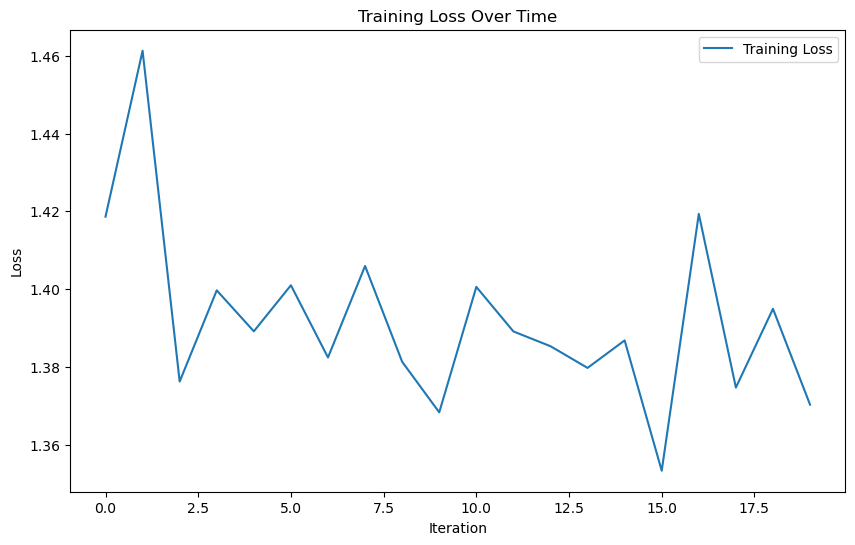

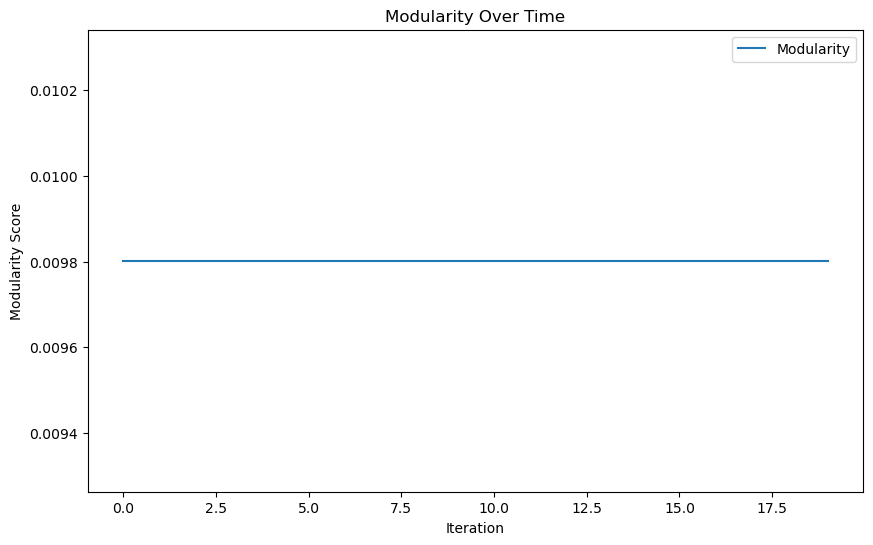

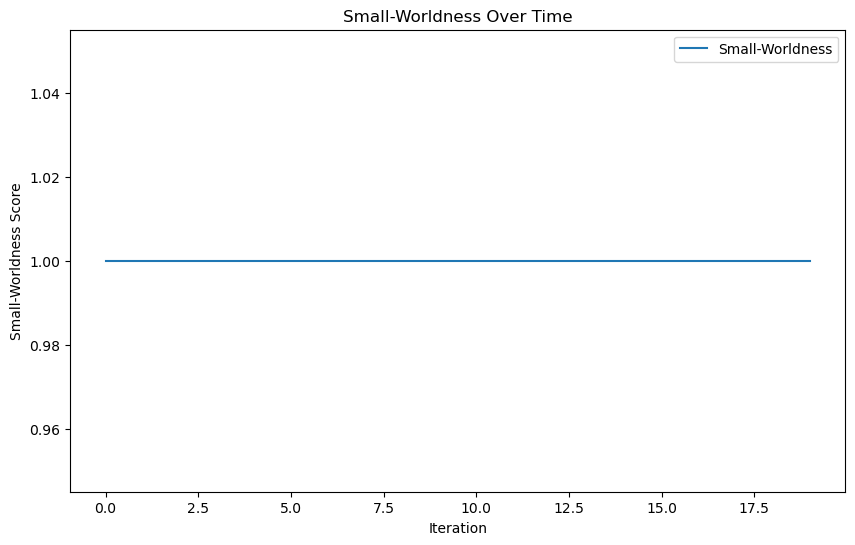

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = 8  # Number of input features
hidden_size = 100
num_layers = 1
num_classes = 4  # Number of output classes
batch_size = 64
learning_rate = 0.001
num_epochs = 20
l1_lambda = 0.001

# Generate some random data for training and testing
# (Replace this with actual data loading for your use case)
def generate_dummy_data(num_samples):
    X = torch.randn(num_samples, 10, input_size)  # Shape: (samples, time_steps, features)
    y = torch.randint(0, num_classes, (num_samples,))  # Random integer labels
    return TensorDataset(X, y)

train_loader = DataLoader(generate_dummy_data(5120), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(generate_dummy_data(2000), batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Regularization functions
def l1_reg(model, l1_lambda):
    return l1_lambda * sum(weight.abs().sum() for weight in model.parameters())

def l2_reg(model, l2_lambda):
    return l2_lambda * sum(weight.pow(2).sum() for name, weight in model.named_parameters())

# Modularity computation
def compute_modularity(weight_matrix):
    binary_matrix = (weight_matrix != 0).astype(int)
    G = nx.from_numpy_array(binary_matrix)
    communities = list(nx.algorithms.community.greedy_modularity_communities(G))
    return nx.algorithms.community.modularity(G, communities)

# Small-worldness computation
def compute_small_worldness(weight_matrix):
    G = nx.from_numpy_array((weight_matrix != 0).astype(int))
    clustering = nx.average_clustering(G)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = float('inf')

    random_graph = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
    C_random = nx.average_clustering(random_graph)
    L_random = nx.average_shortest_path_length(random_graph)
    return (clustering / C_random) / (path_length / L_random)

# Track metrics
losses, modularity_scores, small_worldness_scores = [], [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) + l2_reg(model, l1_lambda)
        loss.backward()
        optimizer.step()

        # Track metrics
        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            losses.append(loss.item())

            # Extract weights and compute metrics
            weight_hh_l0 = model.rnn.weight_hh_l0.detach().cpu().numpy()
            modularity_scores.append(compute_modularity(weight_hh_l0))
            small_worldness_scores.append(compute_small_worldness(weight_hh_l0))

# Evaluation loop
model.eval()
correct, total = 0, 0
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model: {100 * correct / total:.2f}%')

# Plotting helper function
def plot_metric(values, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(values, label=title)
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(f'{title} Over Time')
    plt.legend()
    plt.show()

# Plot the metrics
plot_metric(losses, 'Training Loss', 'Loss')
plot_metric(modularity_scores, 'Modularity', 'Modularity Score')
plot_metric(small_worldness_scores, 'Small-Worldness', 'Small-Worldness Score')



### Graph Losses

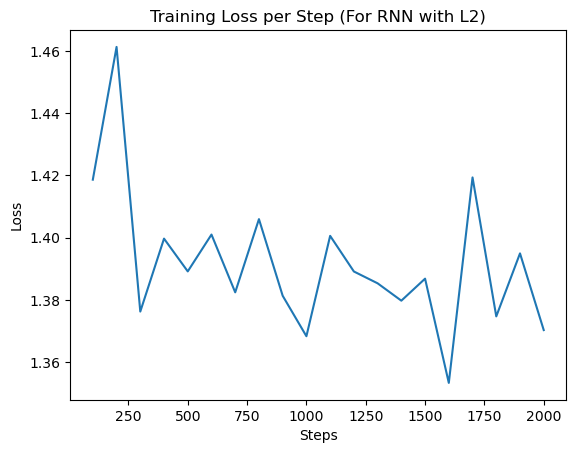

In [37]:
plt.plot(np.array(range(1,len(losses)+1)) * 100,losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss per Step (For RNN with L2)")
plt.show()

### Modularity

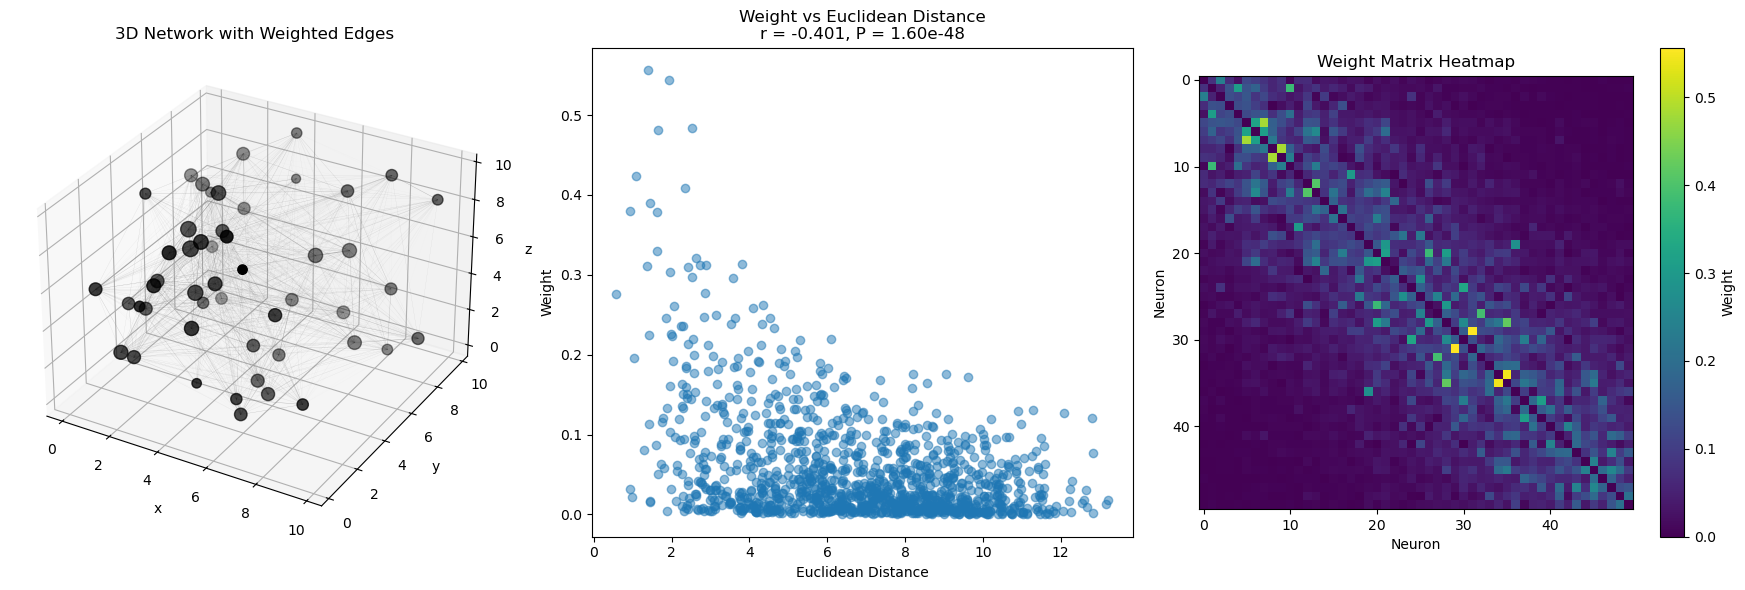

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr

# Generate a sample 3D network graph
np.random.seed(42)
num_nodes = 50
G = nx.Graph()
positions = np.random.rand(num_nodes, 3) * 10  # Random 3D positions for nodes

# Generate weights inversely proportional to distance with added noise
weights = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        euclidean_dist = np.linalg.norm(positions[i] - positions[j])
        weight = (1 / (euclidean_dist + 0.1) + np.random.normal(0, 0.05)) * np.exp(-abs(i - j) / 10)
        weights[i, j] = max(0, weight)  # Ensure weights are non-negative
        weights[j, i] = weights[i, j]

# Add nodes and edges to the graph with computed weights
for i in range(num_nodes):
    G.add_node(i, pos=positions[i])

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        G.add_edge(i, j, weight=weights[i, j])

# Compute node strengths for node sizes
node_strength = [sum(d['weight'] for _, _, d in G.edges(node, data=True)) for node in G.nodes]

# 1. 3D Network Visualization with reduced node size
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, projection='3d')
for edge in G.edges(data=True):
    x = [positions[edge[0]][0], positions[edge[1]][0]]
    y = [positions[edge[0]][1], positions[edge[1]][1]]
    z = [positions[edge[0]][2], positions[edge[1]][2]]
    ax1.plot(x, y, z, 'gray', alpha=0.5, linewidth=edge[2]['weight'])

# Plot nodes with reduced size proportional to strength
node_sizes = [30 * strength for strength in node_strength]  # Smaller scaling factor
ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=node_sizes, c='black')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("3D Network with Weighted Edges")

# 2. Scatter Plot of Weight vs Euclidean Distance with added noise
distances = []
weights_flat = []
for edge in G.edges(data=True):
    pos1, pos2 = positions[edge[0]], positions[edge[1]]
    euclidean_dist = np.linalg.norm(pos1 - pos2)
    distances.append(euclidean_dist)
    weights_flat.append(edge[2]['weight'])

# Calculate Pearson's correlation coefficient
correlation, p_value = pearsonr(distances, weights_flat)

ax2 = fig.add_subplot(132)
ax2.scatter(distances, weights_flat, alpha=0.5)
ax2.set_xlabel("Euclidean Distance")
ax2.set_ylabel("Weight")
ax2.set_title(f"Weight vs Euclidean Distance\nr = {correlation:.3f}, P = {p_value:.2e}")

# 3. Heatmap of Weight Matrix with higher values near the diagonal
weight_matrix = np.zeros((num_nodes, num_nodes))
for i, j, data in G.edges(data=True):
    weight_matrix[i, j] = data['weight']
    weight_matrix[j, i] = data['weight']  # Assuming undirected graph

ax3 = fig.add_subplot(133)
cax = ax3.imshow(weight_matrix, cmap="viridis", interpolation="nearest")
fig.colorbar(cax, ax=ax3, label="Weight")
ax3.set_title("Weight Matrix Heatmap")
ax3.set_xlabel("Neuron")
ax3.set_ylabel("Neuron")

plt.tight_layout()
plt.show()


### Small Worldness

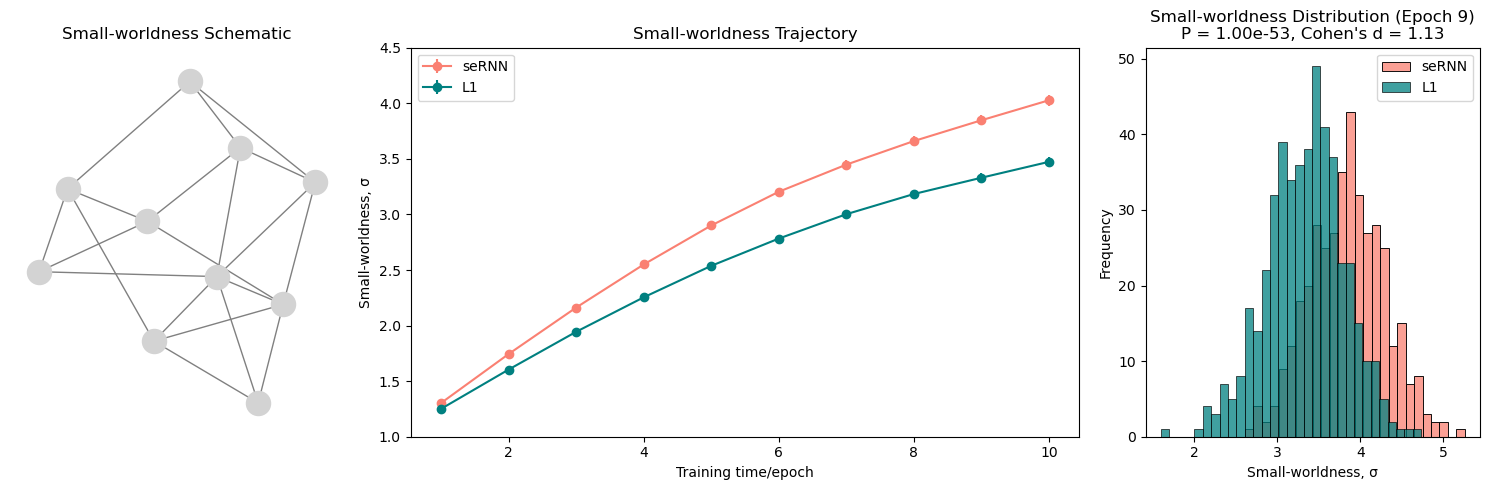

In [62]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
#Only once per epoch because its expensive
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_ind
import seaborn as sns

# Define a function to calculate small-worldness
def calculate_small_worldness(G):
    clustering = nx.average_clustering(G)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = float('inf')
    
    # Generate a random graph with the same number of nodes and edges for comparison
    random_graph = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
    C_random = nx.average_clustering(random_graph)
    L_random = nx.average_shortest_path_length(random_graph)
    
    # Small-worldness measure: (C / C_random) / (L / L_random)
    small_worldness = (clustering / C_random) / (path_length / L_random)
    return small_worldness

# Simulate small-worldness over epochs for two network types
epochs = 10
n_seRNN = 390
n_L1 = 479

np.random.seed(42)
seRNN_small_worldness = [1.0 + np.cumsum(np.random.normal(0.3, 0.15, epochs)) + np.sin(np.linspace(0, np.pi, epochs)) * 0.4 for _ in range(n_seRNN)]
L1_small_worldness = [1.0 + np.cumsum(np.random.normal(0.25, 0.15, epochs)) + np.sin(np.linspace(0, np.pi, epochs)) * 0.3 for _ in range(n_L1)]

# Calculate mean and standard error
seRNN_mean = np.mean(seRNN_small_worldness, axis=0)
seRNN_std_err = np.std(seRNN_small_worldness, axis=0) / np.sqrt(n_seRNN)
L1_mean = np.mean(L1_small_worldness, axis=0)
L1_std_err = np.std(L1_small_worldness, axis=0) / np.sqrt(n_L1)

# Small-worldness distribution at epoch 9
seRNN_epoch_9 = [s[8] for s in seRNN_small_worldness]
L1_epoch_9 = [s[8] for s in L1_small_worldness]

# Statistical test
t_stat, p_value = ttest_ind(seRNN_epoch_9, L1_epoch_9)
cohen_d = (np.mean(seRNN_epoch_9) - np.mean(L1_epoch_9)) / np.sqrt((np.std(seRNN_epoch_9) ** 2 + np.std(L1_epoch_9) ** 2) / 2)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2, 1]})

# Left Panel: Schematic illustration of small-worldness
G_example = nx.watts_strogatz_graph(10, 4, 0.3)
pos = nx.spring_layout(G_example)
nx.draw(G_example, pos, ax=axes[0], node_size=300, node_color="lightgray", with_labels=False, edge_color='gray')
axes[0].set_title("Small-worldness Schematic")

# Middle Panel: Small-worldness over epochs
axes[1].errorbar(range(1, epochs + 1), seRNN_mean, yerr=2 * seRNN_std_err, label="seRNN", color="salmon", marker='o')
axes[1].errorbar(range(1, epochs + 1), L1_mean, yerr=2 * L1_std_err, label="L1", color="teal", marker='o')
axes[1].set_xlabel("Training time/epoch")
axes[1].set_ylabel("Small-worldness, σ")
axes[1].set_title("Small-worldness Trajectory")
axes[1].legend()
axes[1].set_ylim(1.0, 4.5)  # Extended y-axis range for better visibility of variations

# Right Panel: Histogram of small-worldness at epoch 9
sns.histplot(seRNN_epoch_9, color="salmon", label="seRNN", ax=axes[2], kde=False, binwidth=0.1)
sns.histplot(L1_epoch_9, color="teal", label="L1", ax=axes[2], kde=False, binwidth=0.1)
axes[2].set_xlabel("Small-worldness, σ")
axes[2].set_ylabel("Frequency")
axes[2].set_title(f"Small-worldness Distribution (Epoch 9)\nP = {p_value:.2e}, Cohen's d = {cohen_d:.2f}")
axes[2].legend()

plt.tight_layout()
plt.show()



In [63]:
print(model.state_dict()["rnn.weight_hh_l0"].clone())

tensor([[ 3.9789e-03, -5.4514e-03, -6.2088e-04,  ..., -8.1918e-03,
         -1.8550e-02,  1.7646e-02],
        [-9.8131e-03, -3.8423e-03, -1.5833e-02,  ..., -1.7645e-02,
          4.1090e-02, -6.2061e-03],
        [-9.1926e-03,  1.6622e-02,  1.2298e-02,  ..., -2.6715e-02,
          1.8127e-02,  7.8892e-03],
        ...,
        [ 5.8915e-03,  8.6390e-04, -5.0685e-03,  ..., -5.2601e-03,
          1.5019e-02,  3.2615e-02],
        [-7.9701e-03, -1.9649e-02,  1.5096e-05,  ..., -1.8009e-03,
          5.8024e-02, -7.8188e-03],
        [-6.6360e-03,  7.9374e-04,  3.2505e-02,  ..., -1.5183e-02,
         -4.0569e-02, -1.9426e-02]])


In [64]:
#___RESULTS____
#97.51% - L2 regularization, hidden size = 180
#96.55% - L2 regularization, hidden size = 70
# 95.2%- L1 regularization l1, hidden size = 100
i = 0
for n, p in model.named_parameters():
    i += 1
    if p.requires_grad:
         print(p.data.shape)
         print(n)
         print(i)

#I want to look at rnn.weight_hh_l0, and rnn.weight_hh_l1. These are where the recurrent connections are present.


torch.Size([100, 8])
rnn.weight_ih_l0
1
torch.Size([100, 100])
rnn.weight_hh_l0
2
torch.Size([100])
rnn.bias_ih_l0
3
torch.Size([100])
rnn.bias_hh_l0
4
torch.Size([4, 100])
fc.weight
5
torch.Size([4])
fc.bias
6
